In [1]:
from mt.mechanical import *

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
path = "../../02_Data/MechanicalTests/"
tensile = load_set(path + "tensile/")
four_point = load_set(path + "fourPoint/")
three_point = load_set(path + "threePoint/")

C:\Users\malte\OneDrive\Documents\StudiumDocs\MatSci_Ma\Thesis\03_Computation\mt\mechanical.py:53: UserWarning: Break index is at 411 which is less than 60% of the data. You might want to check the break threshold.
  warnings.warn(


In [6]:
data = to_df(
        tensile, 
        # three_point,
        # four_point
)

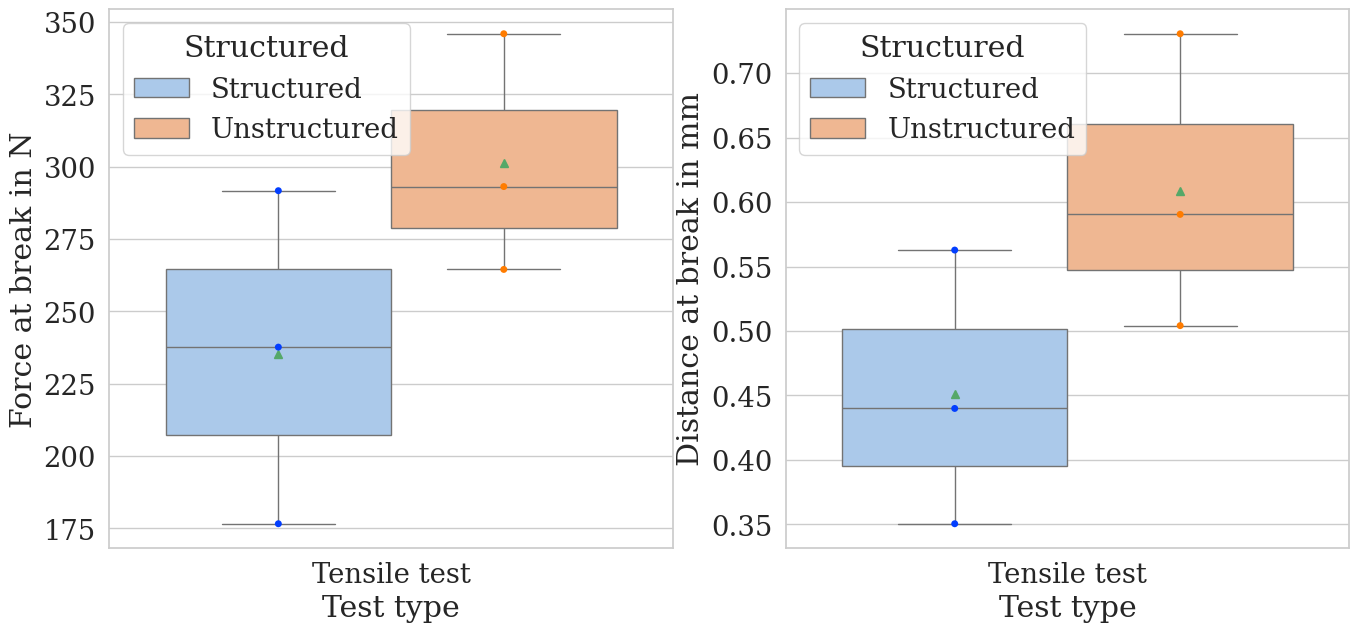

In [7]:
sns.set_theme(font_scale=1.8, font="serif", style="whitegrid")
fig, axs = plt.subplots(1, 2, figsize=(16, 7))
sns.boxplot(x="Test type",
            y="Force at break in N",
            hue="Structured",
            data=data,
            ax=axs[0],
            showmeans=True,
            legend=True,
            palette="pastel")
sns.swarmplot(x="Test type",
              y="Force at break in N",
              hue="Structured",
              data=data,
              dodge=True,
              ax=axs[0],
              legend=False,
              palette="bright")
sns.boxplot(x="Test type",
            y="Distance at break in mm",
            hue="Structured",
            data=data,
            ax=axs[1],
            showmeans=True,
            palette="pastel")
sns.swarmplot(x="Test type",
              y="Distance at break in mm",
              hue="Structured",
              data=data,
              dodge=True,
              ax=axs[1],
              legend=False,
              palette="bright")
plt.savefig(path.replace("02_Data", "06_Results") + "box_plots_tensile.pdf")

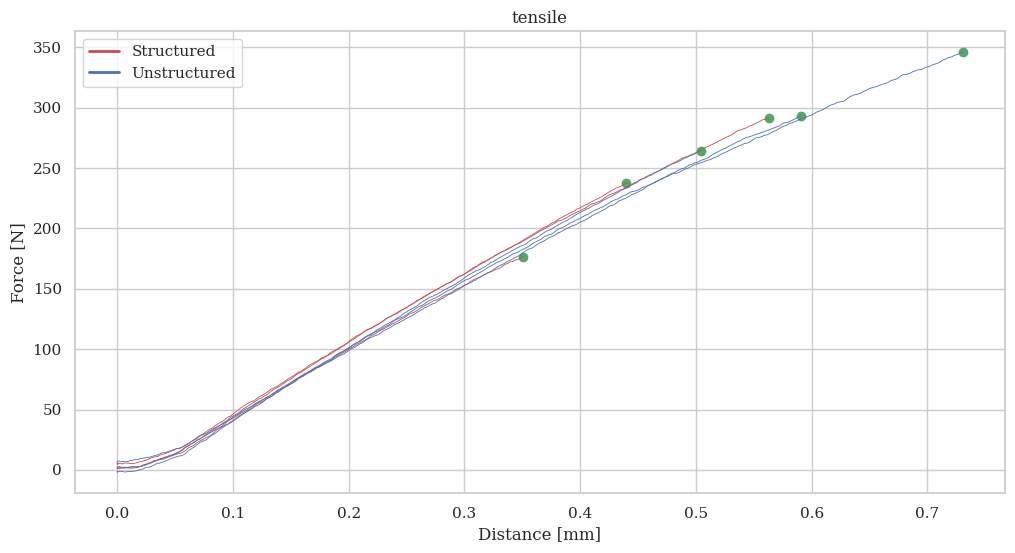

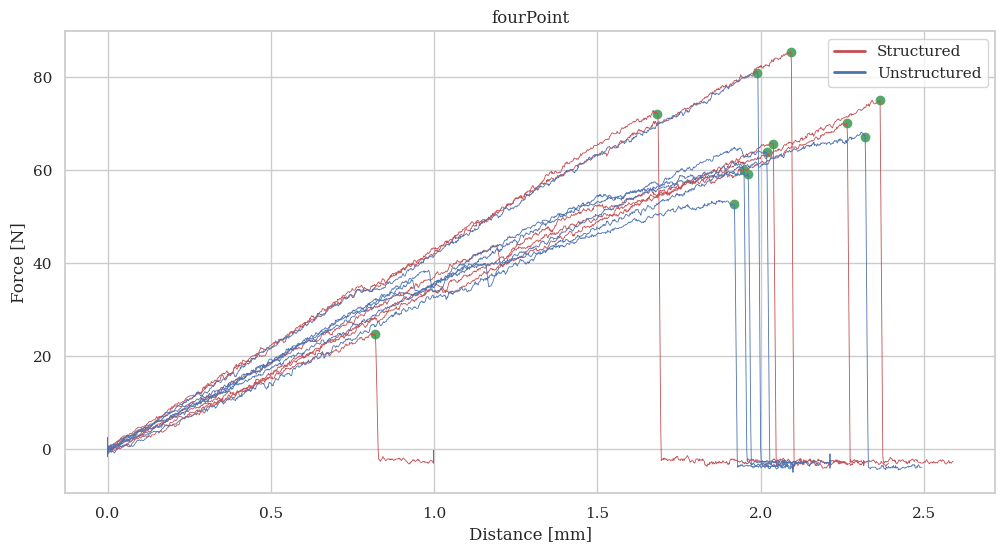

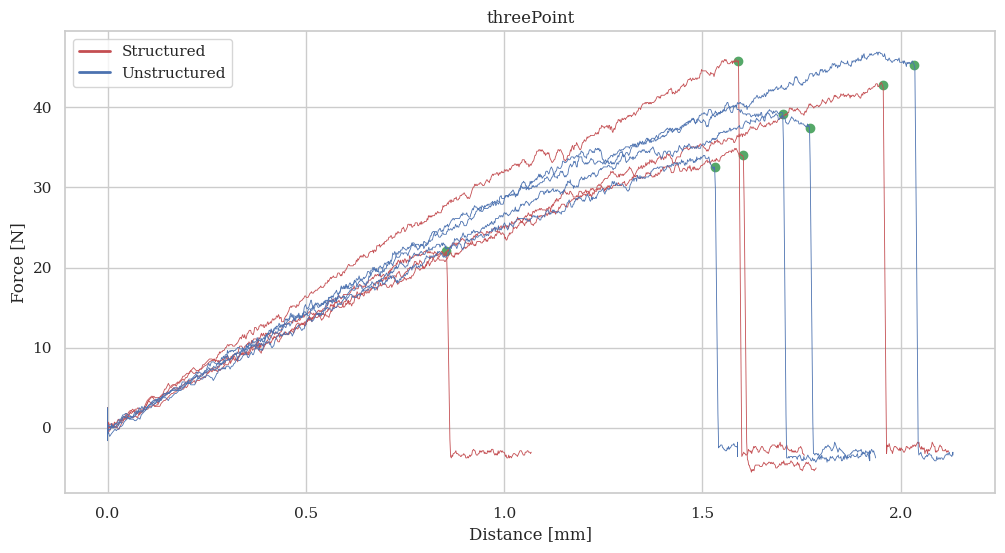

In [5]:
plot_set(tensile)
plot_set(four_point)
plot_set(three_point)